In [1]:
#dependencies
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from config import consumer_key, consumer_secret, access_token, access_token_secret


# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Target Search Term
target_term = ["@BBC", "@CBS", "@CNN", "@nytimes", "@FoxNews"]

target_df = pd.DataFrame({"User": target_term})
target_df['Compound Score'] = ''
target_df['Positive Score'] = ''
target_df['Negative Score'] = ''
target_df['Neutral Score'] = ''

target_df

,User,Compound Score,Positive Score,Negative Score,Neutral Score
0,@BBC,,,,
1,@CBS,,,,
2,@CNN,,,,
3,@nytimes,,,,
4,@FoxNews,,,,


In [3]:
# Grab 100 tweets

sentiments = []

oldest_tweet = None

for target in target_term:
    public_tweets = api.user_timeline(target, max_id=oldest_tweet)
    
    counter = 1
    
    # Loop through all tweets
    for tweet in public_tweets:

        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweet['text'])
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]
        tweets_ago = counter
        
        oldest_tweet = tweet['id'] - 1
        
        sentiments.append({"Date": tweet['created_at'],
                          "Compound": compound,
                          "Positive": pos,
                          "Negative": neg,
                          "Neutral": neu,
                          "Tweets Ago": counter})
        
        counter += 1

In [4]:
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.head()

,Compound,Date,Negative,Neutral,Positive,Tweets Ago
0,0.4696,Thu Jun 28 16:13:35 +0000 2018,0.000,0.861,0.139,1
1,-0.1280,Thu Jun 28 16:00:25 +0000 2018,0.133,0.753,0.115,2
2,0.0000,Thu Jun 28 15:52:28 +0000 2018,0.000,1.000,0.000,3
3,0.4963,Thu Jun 28 15:22:37 +0000 2018,0.052,0.761,0.188,4
4,0.6369,Thu Jun 28 13:00:23 +0000 2018,0.090,0.676,0.234,5


In [5]:
#okay testing all of that was nice and all but now i have to make a function
# 1. Function will take in the string name of a twitter user.
# 2. It will spit out that sentiments pd ^ up there when called.
# 3. Calling a function will look like sentimentblender("@CNN")

def sentimentblender(user):
    target_user = user
    
    counter = 1
    
    sentiments = []
    
    oldest_tweet = None
    
    for x in range(5):
        public_tweets = api.user_timeline(target_user, max_id=oldest_tweet)
        
        for tweet in public_tweets:
            
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter
        
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiments.append({"User": target_user,
                                "Date": tweet["created_at"], 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1
            
    return pd.DataFrame.from_dict(sentiments)
    

In [6]:
bbc_df = sentimentblender("@BBC")
cbs_df = sentimentblender("@CBS")
cnn_df = sentimentblender("@CNN")
nyt_df = sentimentblender("@nytimes")
fox_df = sentimentblender("@FoxNews")

bbc_df.head()

,Compound,Date,Negative,Neutral,Positive,Tweets Ago,User
0,0.4696,Thu Jun 28 16:13:35 +0000 2018,0.861,0.000,0.139,1,@BBC
1,-0.1280,Thu Jun 28 16:00:25 +0000 2018,0.753,0.133,0.115,2,@BBC
2,0.0000,Thu Jun 28 15:52:28 +0000 2018,1.000,0.000,0.000,3,@BBC
3,0.4963,Thu Jun 28 15:22:37 +0000 2018,0.761,0.052,0.188,4,@BBC
4,0.6369,Thu Jun 28 13:00:23 +0000 2018,0.676,0.090,0.234,5,@BBC


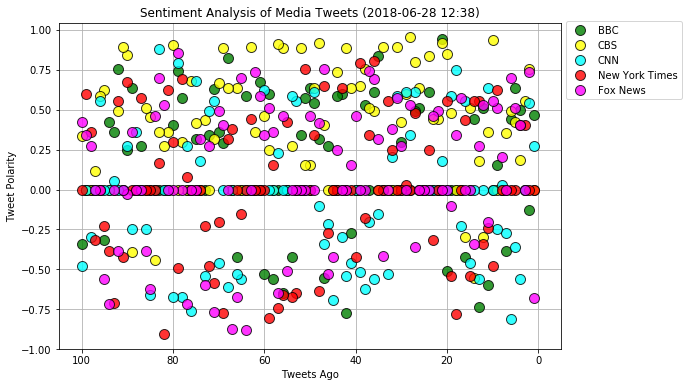

In [7]:
plt.figure(figsize=(9,6))
plt.plot(bbc_df['Tweets Ago'], bbc_df['Compound'], marker="o", ms=10, color="green", mec="black", linewidth=0, alpha=0.8, label="BBC")
plt.plot(cbs_df['Tweets Ago'], cbs_df['Compound'], marker="o", ms=10, color="yellow", mec="black", linewidth=0, alpha=0.8, label="CBS")
plt.plot(cnn_df['Tweets Ago'], cnn_df['Compound'], marker="o", ms=10, color="cyan", mec="black", linewidth=0, alpha=0.8, label="CNN")
plt.plot(nyt_df['Tweets Ago'], nyt_df['Compound'], marker="o", ms=10, color="red", mec="black", linewidth=0, alpha=0.8, label="New York Times")
plt.plot(fox_df['Tweets Ago'], fox_df['Compound'], marker="o", ms=10, color="fuchsia", mec="black", linewidth=0, alpha=0.8, label="Fox News")

now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")
plt.xlim(105,-5)
plt.title(f"Sentiment Analysis of Media Tweets ({now} GMT)")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.legend(loc="best", bbox_to_anchor=(1.25, 1.02))
plt.grid(True)
plt.show()

In [8]:
#concatenate the dfs to put them all in one big df
dfs = [bbc_df, cbs_df, cnn_df, nyt_df, fox_df]
concat_dfs = pd.concat(dfs)

#groupby user
usergroup = concat_dfs.groupby('User')

usergroup.head(2)

,Compound,Date,Negative,Neutral,Positive,Tweets Ago,User
0,0.4696,Thu Jun 28 16:13:35 +0000 2018,0.861,0.000,0.139,1,@BBC
1,-0.1280,Thu Jun 28 16:00:25 +0000 2018,0.753,0.133,0.115,2,@BBC
0,0.0000,Wed Jun 27 20:31:32 +0000 2018,1.000,0.000,0.000,1,@CBS
1,0.7574,Wed Jun 27 14:00:01 +0000 2018,0.711,0.000,0.289,2,@CBS
0,0.2732,Thu Jun 28 16:26:51 +0000 2018,0.890,0.000,0.110,1,@CNN
1,0.5423,Thu Jun 28 16:13:50 +0000 2018,0.769,0.000,0.231,2,@CNN
0,0.0000,Thu Jun 28 16:30:20 +0000 2018,1.000,0.000,0.000,1,@nytimes
1,0.0000,Thu Jun 28 16:20:09 +0000 2018,1.000,0.000,0.000,2,@nytimes
0,-0.6808,Thu Jun 28 16:26:25 +0000 2018,0.705,0.295,0.000,1,@FoxNews
1,0.7351,Thu Jun 28 16:12:00 +0000 2018,0.563,0.000,0.437,2,@FoxNews


In [28]:
usernames = concat_dfs['User'].unique().tolist()
meancompound = usergroup['Compound'].mean()

meancompound

User
@BBC        0.132641
@CBS        0.355032
@CNN       -0.018429
@FoxNews    0.099888
@nytimes    0.016063
Name: Compound, dtype: float64

0.13264099999999998
0.355032
-0.018429
0.09988799999999996
0.016063


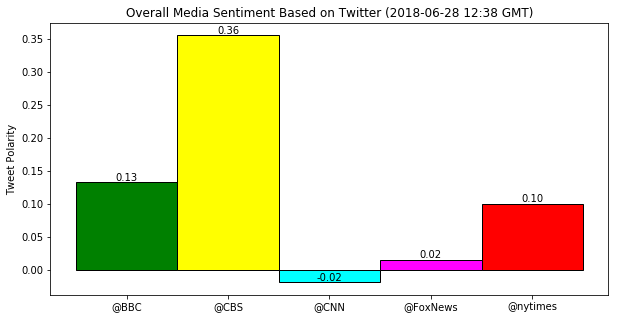

In [41]:
plt.figure(figsize=(10,5))
colors = ['green', 'yellow', 'cyan', 'red', 'fuchsia']
sentbars = plt.bar(usernames, meancompound, align='center', color=colors, edgecolor='black', width=1.0)
plt.ylabel("Tweet Polarity")
plt.title(f"Overall Media Sentiment Based on Twitter ({now} GMT)")

# numbers on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, '%.2f' %float(height), ha='center', va='bottom')
        print(height)
        
autolabel(sentbars)

plt.show()